# Сборный проект - 2 HR-аналитика

## Описание проекта

В данном проекте требуется решить две задачи: 
 - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика,
 - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

__Цель первой задачи:__ 
предсказание уровня удовлетворённости сотрудника для возможности HR влиять на отток из компании.
__Описание данных для первой задачи__ : 

Данные представлены тремя файлами:
 - Тренировочная выборка:
train_job_satisfaction_rate.csv
 - Входные признаки тестовой выборки:
test_features.csv
 - Целевой признак тестовой выборки количественный job_satisfaction_rate:
test_target_job_satisfaction_rate.csv

Признаки в выборках следующие:

id — уникальный идентификатор сотрудника;

dept — отдел, в котором работает сотрудник;

level — уровень занимаемой должности;

workload — уровень загруженности сотрудника;

employment_years — длительность работы в компании (в годах);

last_year_promo — показывает, было ли повышение за последний год;

last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;

supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;

salary — ежемесячная зарплата сотрудника;

job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

__Шаги для выполнения первой задачи__:

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка данных
5. Обучение моделей и оценка качества модели метрикой SMAPE
6. Оформление выводов

__Цель второй задачи:__
предсказание увольнения сотрудника из компании для возможности HR влиять на отток из компании.

__Описание данных для второй задачи__ : 

Данные представлены тремя файлами:
 - Тренировочная выборка:
train_quit.csv
 - Входные признаки тестовой выборки те же, что и в первой задаче:
test_features.csv
 - Целевой признак тестовой выборки категориальный quit:
test_target_quit.csv

__Шаги для выполнения второй задачи__:

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Добавление нового входного признака
5. Подготовка данных
6. Обучение моделей и оценка качества модели метрикой ROC-AUC
7. Сравнение моделей
8. Общий вывод



## Задача 1. Предсказание уровня удовлетворённости сотрудника 

### Загрузка данных

In [1]:
# установка библиотеки нужной версии
!pip install scikit-learn==1.6.1 -q
#импорт необходимых библиотек
import pandas as pd
#импортируем библиотеку matplotlib.pyplot для построения визуальных представлений данных
import matplotlib.pyplot as plt
#импортируем библиотеку для построения диаграммы размаха
import seaborn as sns
#импорт модуля регулярных выражений
import re 
# установим библиотеку для корреляционного анализа
!pip install phik -q
import phik
#импортируем библиотеку для работы с массивами
import numpy as np
# импортируйте функцию для разделения датасета на выборки
from sklearn.model_selection import train_test_split
# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer
# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
# импортируем класс для подбора гиперпараметров RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
# импортируем методы для оценки качества классификации
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# импортируем метод для построения матрицы ошибок
from sklearn.metrics import confusion_matrix
# импортируем метод для создания своей метрики
from sklearn.metrics import make_scorer

#импортируем модель "случайный лес"
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor


# импортируем библиотеку для оценки признаков
!pip install shap -q
import shap

In [2]:
#настройка размера графиков
plt.rcParams["figure.figsize"] = (14,15)
sns.set_style('whitegrid')

#фиксация констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
#извлекаем данные из файлов
X_train = pd.read_csv('train_job_satisfaction_rate.csv',  sep = ',', decimal = '.')
X_test = pd.read_csv('test_features.csv', sep = ',')
y_test = pd.read_csv('test_target_job_satisfaction_rate.csv', sep = ',', decimal = '.')
#выведем названия столбцов
print(X_train.columns)
print(X_test.columns)
y_test.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')
Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary'],
      dtype='object')


Index(['id', 'job_satisfaction_rate'], dtype='object')

In [4]:
#просмотр информации о составе и типе данных
X_train.info()
X_test.info()
y_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----

In [5]:
#просмотр данных
display(X_train.head())
display(X_test.head())
display(y_test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Вывод по разделу: данные в таблицах соответствуют описанию

### Предобработка данных

In [6]:
#выполним поиск явных дубликатов
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())
y_test.duplicated().sum()

0
0


0

In [7]:
#поиск неявных дубликатов в X_train
def dup(columns):
    unique_values = X_train[columns].unique()
    return unique_values

for i in list(X_train.select_dtypes(include='object').columns):
    print(dup(i))

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


В X_train есть пропуски и неверно написано слово sinior. Оставим пока sinior без изменений, а пропуски обработаем в пайплайне.

In [8]:
#поиск неявных дубликатов в X_test
def dup(columns):
    unique_values = X_test[columns].unique()
    return unique_values

for i in list(X_test.select_dtypes(include='object').columns):
    print(dup(i))

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


В X_test есть пустые значения в столбцах dept и workload, заменим их на nan. NAN в дальнейшем обработаем в пайплайне.

In [9]:
#проверим
def dup(columns):
    unique_values = X_train[columns].unique()
    return unique_values

for i in list(X_train.select_dtypes(include='object').columns):
    print(dup(i))
    
def dup(columns):
    unique_values = X_test[columns].unique()
    return unique_values

for i in list(X_test.select_dtypes(include='object').columns):
    print(dup(i))

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Вывод по разделу: Названия колонок преобразования не требуют. Дубликаты отсутствуют. изменение типов данных не требуется. Пропуски будут обработаны в пайплайне.

### Исследовательский анализ данных

__Статистический анализ признаков__

In [10]:
#выведем описание данных для числовых столбцов датафреймов
dfs = [ 
    X_train,
    X_test,
    y_test
] 

for df in dfs:
    col_name=df.select_dtypes(include='number').columns.tolist() #создаем список столбцов
    if 'id' in col_name:
        col_name.remove('id') #удаляем столбец с id
        
    display(df[col_name].describe()) #выводим описание данных в столбцах

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


По описанию данных отклонений не видно.

Для числовых признаков построим гистограммы и диаграммы размаха, а для не числовых круговые диаграммы.

Информация по датафрейму 'X_train':



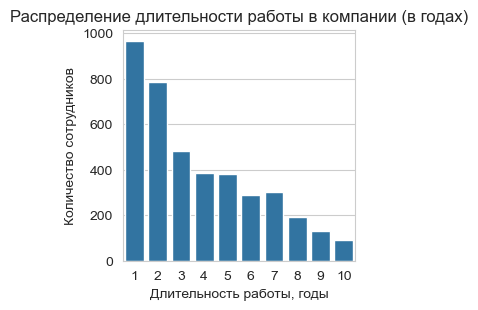

Информация по датафрейму 'X_train':



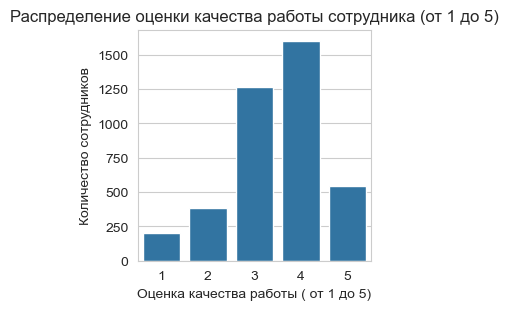

Информация по датафрейму 'X_test':



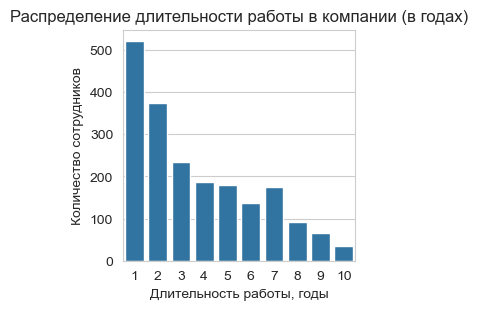

Информация по датафрейму 'X_test':



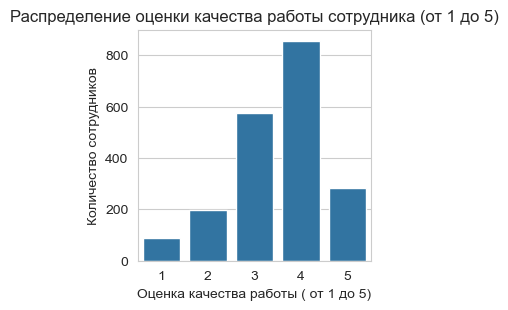

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [11]:
#посторим графики для всех числовых столбцов для оценки распределения данных 

dfs = [ 
    X_train,
    X_test,
   y_test
] 

dictionary = {
    'employment_years': ['Распределение длительности работы в компании (в годах)', 'Длительность работы, годы', 'Количество сотрудников'],
    'supervisor_evaluation':['Распределение оценки качества работы сотрудника (от 1 до 5)','Оценка качества работы ( от 1 до 5)', 'Количество сотрудников'],
    'salary': ['Распределение ежемесячной зарплаты сотрудника', 'Ежемесячная зарплата сотрудника', 'Количество сотрудников'],
    'job_satisfaction_rate':['Распределение уровня удовлетворённости сотрудника (от 0 до 1)', 'Уровень удовлетворённости сотрудника (от 0 до 1)', 'Количество сотрудников']
    }

X_test.__name__ = 'X_test' 
X_train.__name__ = 'X_train'
y_test.__name__ = 'y_test'

col_name_dis = ['employment_years', 'supervisor_evaluation'] #дискретные признаки 
col_name_cont = ['salary', 'job_satisfaction_rate'] #непрерывные признаки


#построим графики для дискретных признаков
for df in dfs:
    for column in col_name_dis:
        try:
            plt.figure(figsize=(3, 3))
            sns.countplot(data=df, x = column)
            print(f"Информация по датафрейму '{df.__name__}':\n")
            for tag, values in dictionary.items(): 
                if column == tag:
                    plt.title(values[0])
                    plt.xlabel(values[1])
                    plt.ylabel(values[2]) 
            plt.show();        
        except ValueError:
            continue

Информация по датафрейму 'X_train':



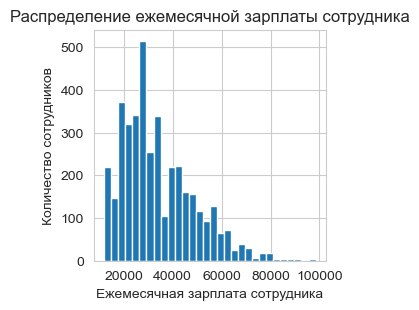

Информация по датафрейму 'X_train':



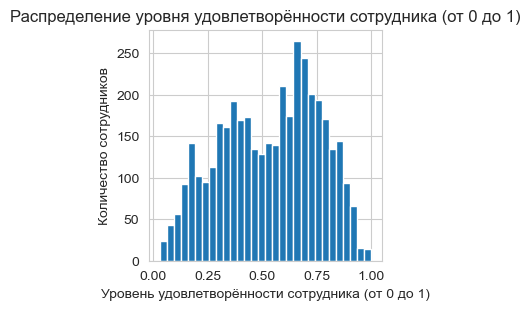

Информация по датафрейму 'X_test':



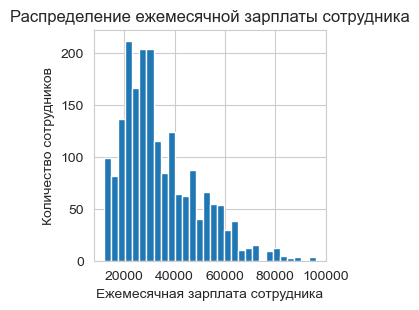

Информация по датафрейму 'y_test':



<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

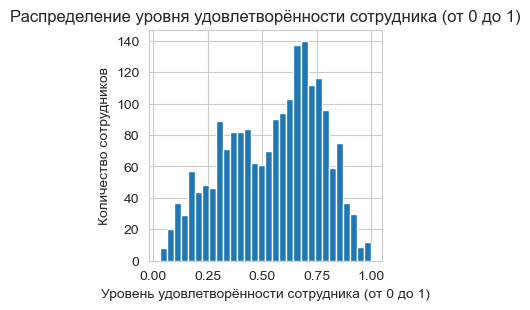

In [12]:
#построим графики распределения для непрерывных признаков
for df in dfs:
    for column in col_name_cont:
        try:
            plt.figure(figsize=(3, 3))
            #sns.countplot(data=df, x = column)
            df[column].hist(bins=30)
            print(f"Информация по датафрейму '{df.__name__}':\n")
            for tag, values in dictionary.items(): 
                if column == tag:
                    plt.title(values[0])
                    plt.xlabel(values[1])
                    plt.ylabel(values[2]) 
            plt.show();        
        except ValueError:
            continue
        except KeyError:
            continue

Из гистограм видно что, признаки имеют распределение похожее на распределение Пуассона, в признаках по зарплате присутсвуют выбросы, в целом распеределения признаков тестовой и тренировочной выборок схожи.

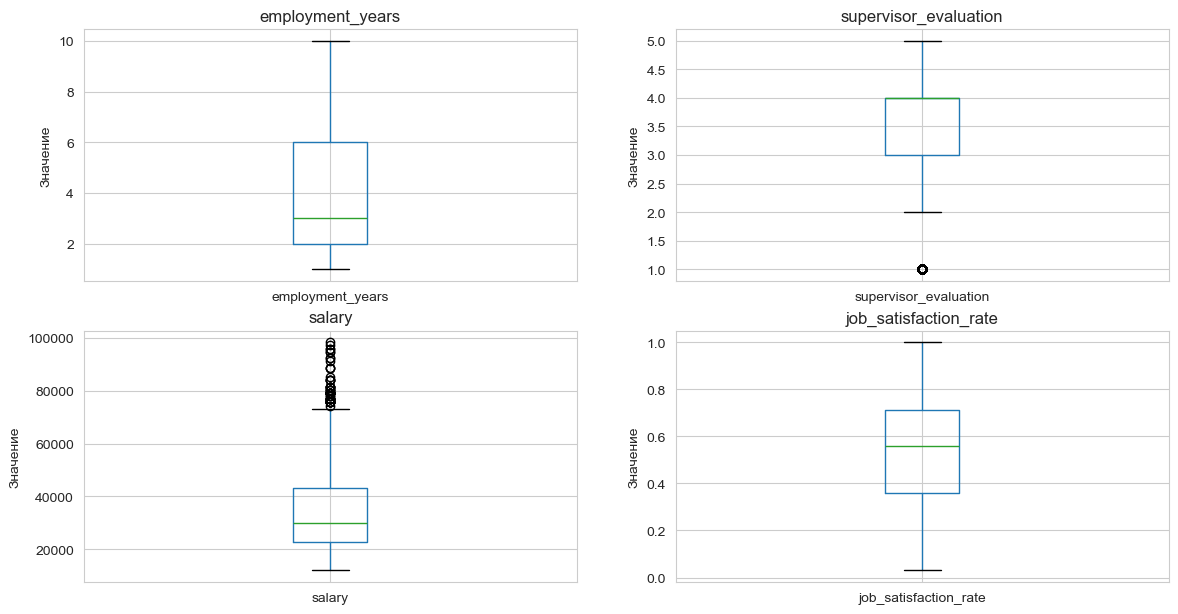

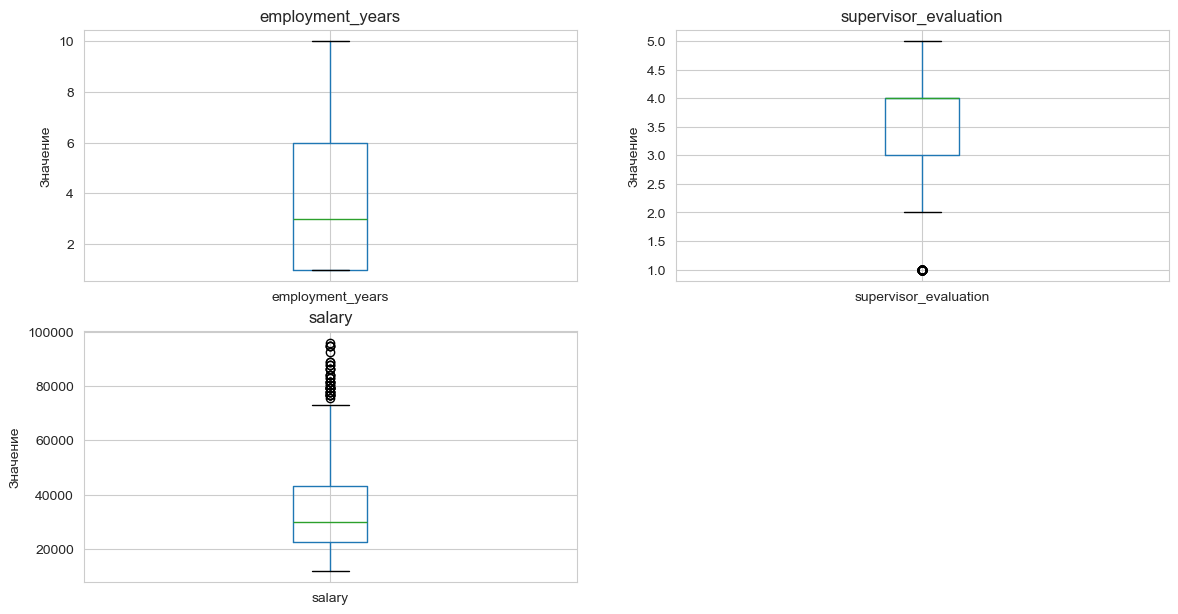

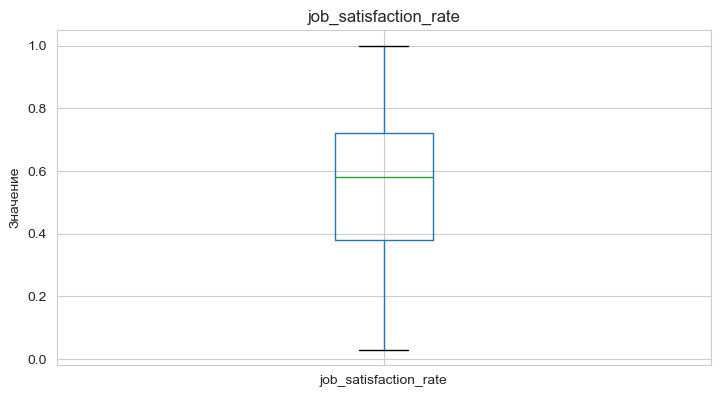

In [13]:
#для дополнительного анализа выбросов построим диаграмму размаха для всех числовых признаков

for df in dfs:    
    
    col_name=df.select_dtypes(include='number').columns.tolist()
    if 'id' in col_name:
        col_name.remove('id')
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(col_name):
        plt.subplot(4,2,i+1)
        df.boxplot(column=column)
        plt.title(column)
       # plt.xlabel(column)
        plt.ylabel('Значение')
plt.tight_layout()
plt.show()

На диаграммах размаха так же наблюдаются выбросы в признаках зарплаты.

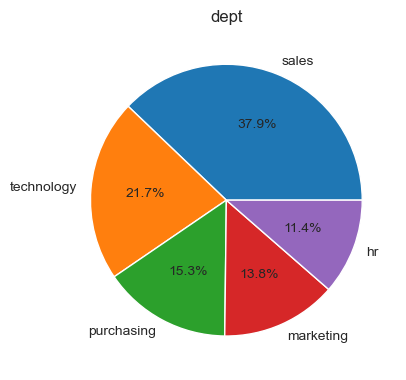

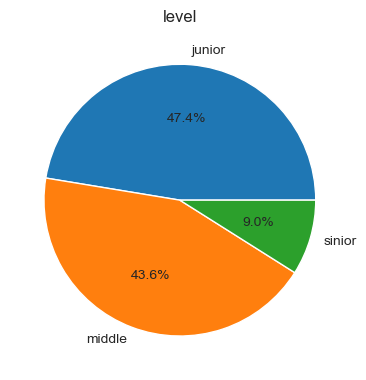

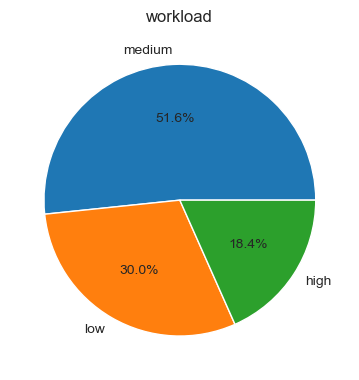

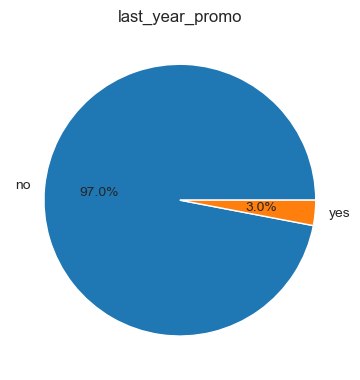

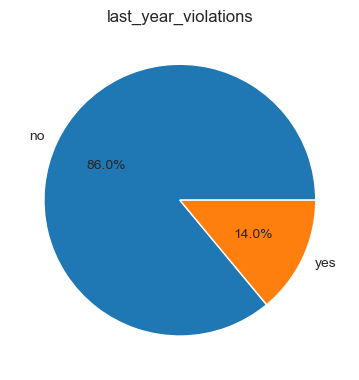

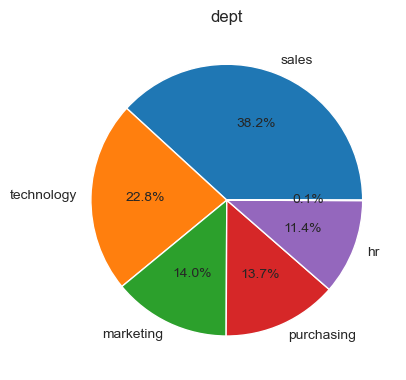

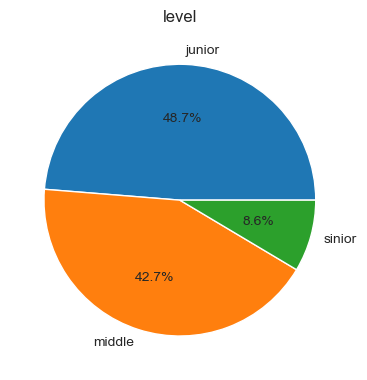

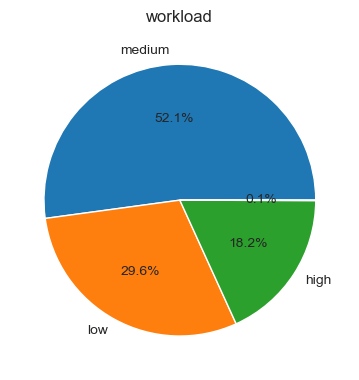

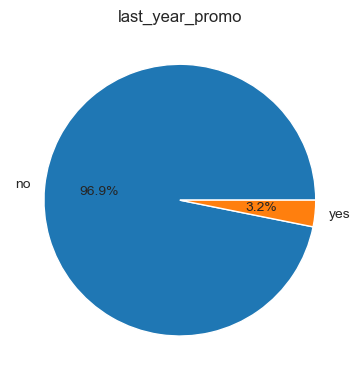

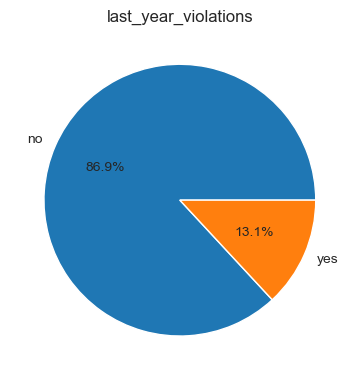

<Figure size 1400x1500 with 0 Axes>

In [14]:
#для категориальных признаков датафрейма построим круговые диаграммы
for df in dfs:    
    plt.figure(figsize=(14, 15))
    col_name=df.select_dtypes(include='object').columns.tolist()
    if 'id' in col_name:
        col_name.remove('id')
    
    
    for i, column in enumerate(col_name):
        plt.subplot(3, 2, i + 1)
        data = df[column].value_counts()
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
        plt.title(column)
        plt.show()

Вывод по разделу:
На круговых диаграммах видно, что:
 - процентные соотношение признаков на тренировочной и тестовой выборках схожи,
 - больше всего сотрудников представлено из дивизиона sales ~ 38%
 - примерное одинаковое соотношение junior и middle специалистов и меньше 9% senior
 - половина сотрудников имеют среднюю нагрузку, высокозагружены 18%
 - в выборках представлено всего 3% сотрудников, которым повышали зарплаты
 - и примерно 14% нарушали ТД
 
 В ходе подготовки данных для обучения моделей потребуется устранять дисбаланс классов у признаков last_year_promo и last_year_violations. 

__Корреляционный анализ__

Рассчитаем коэффициенты корреляции между всеми признаками и выведем их в виде тепловой карты. Из-за присутствия и категориальных и колличественных признаков будем использовать метод phik.

In [15]:
X_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


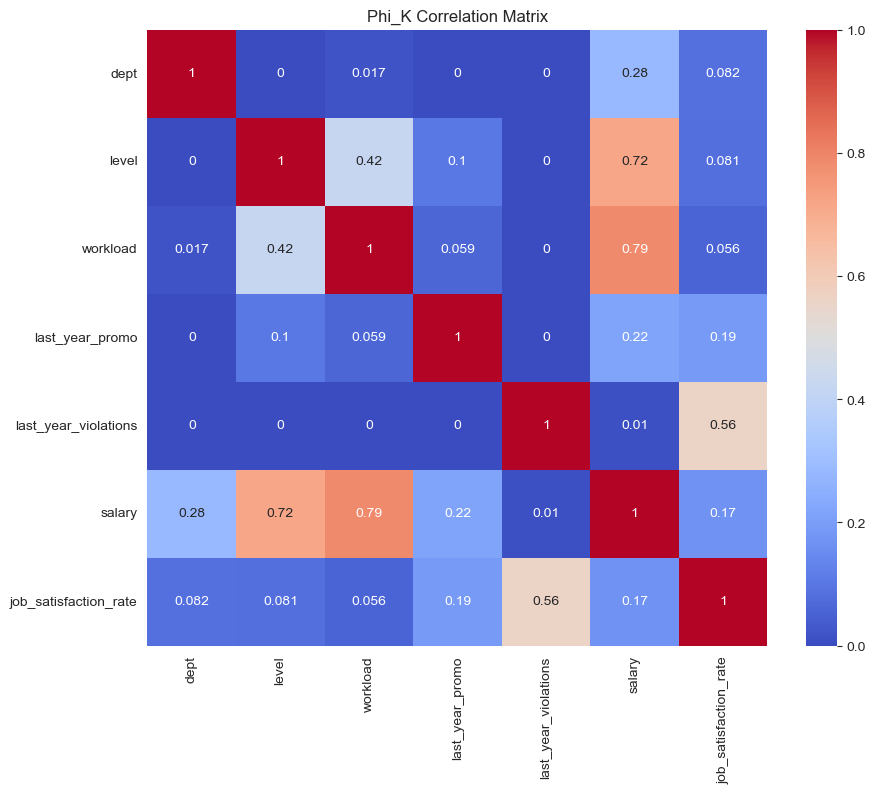

In [16]:
#исключим id
df_train_corr=X_train.drop(columns=['id', 'employment_years', 'supervisor_evaluation' ], axis=1)

#для метода нужен список с количественными признаками
num_columns = df_train_corr.select_dtypes(include='number').columns.tolist()


# Вычисление матрицы корреляции с использованием phik
corr_matrix = df_train_corr.phik_matrix(interval_cols = num_columns)

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

По тепловой карте можно сделать следующие выводы:

 - очень высокие корреляции (0.9 +) отсутствуют, скорее всего мультиколлинеарности нет.

 - у целевого признака "уровень удовлетворённости сотрудника" (job_satisfaction_rate):
     - сильная связь(0.7+) отсутствует,
     - средняя связь(0.5+) с:
         - признаком "нарушение ТД" (last_year_violations)

### Подготовка данных

Перечислим особенности данных:

Целевой признак — job_satisfaction_rate количественный от 0 до 1.

Категориальные признаки: dept, last_year_promo, last_year_violations, нужно кодировать с помощью OneHotEncoder
    
Порядковые категориальные признаки: level, workload,  закодируем с помощью OrdinalEncoder

Количественные признаки: employment_years, supervisor_evaluation, salary. 

В признаках  last_year_promo и last_year_violations присутствует дисбаланс.

In [17]:
#проверим датасеты на совместимость
print(X_test.shape)
y_test.shape

(2000, 9)


(2000, 2)

In [18]:
#объединим датасеты
X_test_merge = pd.merge(X_test, y_test, on = 'id', how = 'inner')
X_test_merge.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [19]:
#проверим размерность и дубликаты
print(X_test_merge.shape)
X_test_merge.duplicated().sum()

(2000, 10)


0

In [20]:
# разделим на входные и целевой признак
y_test = X_test_merge['job_satisfaction_rate']
X_test1= X_test_merge.drop(['job_satisfaction_rate', 'id'], axis=1)

In [21]:
y_test.head()

0    0.79
1    0.72
2    0.64
3    0.60
4    0.75
Name: job_satisfaction_rate, dtype: float64

In [22]:
# выделим из тренировочной выборки целевой признак
y_train = X_train['job_satisfaction_rate']
X_train = X_train.drop(['job_satisfaction_rate', 'id'], axis=1)

In [23]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 
               'supervisor_evaluation', 'salary']

In [24]:
#создадим функцию для замены пропусков на nan
replace_miss=FunctionTransformer(lambda x: x.replace(' ', np.nan))

In [25]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline([
            ('replace_miss', replace_miss), #пропуски заменяем на nan
    
            (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
                #nan заменяем на моду, самое частое значение
            ),
        
        (    'ohe', 
            OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
         
        )
])

In [26]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline([
        ('replace_miss', replace_miss),
        (
            'simpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior', np.nan],
                    ['low', 'medium', 'high', np.nan]
                ], 
                handle_unknown='use_encoded_value', # кодируем неизвестные категории пропусками
                unknown_value=-1
            )
        )
])

In [27]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [28]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)
print(pipe_final)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('replace_miss',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000176BE92AC00>)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse...


In [29]:
#создаем словарь моделей 
param_grid = [
    {
    # словарь для модели DecisionTreeRegressor()
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(1,8),
    'models__min_samples_split': range(2,10),
    'models__min_samples_leaf': range(2,10),
    'models__min_weight_fraction_leaf' : [0.1],
    #'models__max_features': range (2,5),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
     },
    {
        'models': [RandomForestRegressor()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

### Обучение моделей

In [30]:
#формула для вычисления метрики SMAPE 
# создаём функцию для оценки качества модели

def custom_metric(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # вычисляем метрику
    a = np.abs(y_true - y_pred)
    b = (np.abs(y_true) + np.abs(y_pred))/2
      
    mask = (b != 0) #создаем маску, чтобы определить, где b не равно нулю, по которой безопасно вычислять
   #расчитываем метрику
    metric = 100 * (np.mean(a[mask] / b[mask]))
    return metric

# создаём пользовательскую метрику
SMAPE = make_scorer(custom_metric, greater_is_better=False ) #чем ниже значением SMAPE, тем лучше качество модели

In [31]:
#запускаем автоматический подбор гиперпараметров
#осуществляем перебор по сетке, все указанные значения гиперпараметров будут перебираться
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=SMAPE,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('replace_miss',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x00000176BE92AC00>)),
                                                                                         ('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        ha...
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [RandomForestRegressor()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(custom_metric, greater_is_better=False, response_method='predict'))

In [32]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', np.abs(grid_search.best_score_.round(2)))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('replace_miss',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000176BE92AC00>)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                           

In [33]:
display(X_test1.head())
display(y_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,marketing,junior,medium,2,no,no,5,28800
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
4,hr,middle,medium,5,no,no,5,40800


0    0.79
1    0.72
2    0.64
3    0.60
4    0.75
Name: job_satisfaction_rate, dtype: float64

In [34]:
# получите предсказания на тестовых данных с помощью лучшей модели
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred

array([0.86917722, 0.68415593, 0.65436101, ..., 0.22451921, 0.51363333,
       0.587     ])

In [35]:
#переведем в массив y_test
y_test_SMAPE = np.array(y_test)
y_test_SMAPE

array([0.79, 0.72, 0.64, ..., 0.11, 0.43, 0.67])

In [36]:
# Проверяем размерности массивов(они должны совпадать)
print(y_pred.shape)
y_test_SMAPE.shape

(2000,)


(2000,)

In [37]:
# Рассчитайте значение метрики SMAPE
# создаём объект пользовательской метрики
score = np.abs(SMAPE(grid_search, X_test1, y_test_SMAPE))
print(f'Метрика SMAPE на тестовой выборке: {score.round(2)}')

Метрика SMAPE на тестовой выборке: 12.48


In [38]:
model_dr=DummyRegressor()
model_dr.fit(X_train, y_train)
predictions = model_dr.predict(X_test1)

In [39]:
predictions

array([0.533995, 0.533995, 0.533995, ..., 0.533995, 0.533995, 0.533995])

In [40]:
# Рассчитываем значение метрики SMAPE на константной модели
score = np.abs(SMAPE(model_dr, X_test1, y_test_SMAPE))
print(f'Метрика SMAPE на тестовой выборке: {score.round(2)}')

Метрика SMAPE на тестовой выборке: 38.22


__Вывод по разделу__

Метрика константной модели получилась равной 38.22, это значение больше, чем значение метрики модели RandomForestRegressor равной 12.41, а это значит, что качество модели RandomForestRegressor лучше.

## Задача 2. Предсказание увольнения сотрудника из компани

### Загрузка данных

In [42]:
#извлекаем данные из файлов

#Тренировочная выборка
X_train_quit = pd.read_csv('train_quit.csv', sep = ',')

#X_test - Входные признаки тестовой выборки те же, что и в прошлой задаче
X_test2 = X_test

#Целевой признак тестовой выборки quit - увольнение сотрудника из компании
y_test_quit = pd.read_csv('test_target_quit.csv', sep = ',')
#выведем названия столбцов
print(X_train_quit.columns)
y_test_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')


Index(['id', 'quit'], dtype='object')

In [43]:
#просмотр информации о составе и типе данных
X_train_quit.info()
y_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    20

In [44]:
#просмотр данных
display(X_train_quit.head())
display(X_test2.head())
display(y_test_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Вывод по разделу: данные в таблицах соответствуют описанию.

### Предобработка данных

In [45]:
#выполним поиск явных дубликатов
print(X_train_quit.duplicated().sum())
y_test_quit.duplicated().sum()

0


0

In [46]:
#поиск неявных дубликатов в X_train_quit
def dup(columns):
    unique_values = X_train_quit[columns].unique()
    return unique_values

for i in list(X_train_quit.select_dtypes(include='object').columns):
    print(dup(i))

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [47]:
#поиск неявных дубликатов в X_test2
def dup(columns):
    unique_values = X_test2[columns].unique()
    return unique_values

for i in list(X_test2.select_dtypes(include='object').columns):
    print(dup(i))

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


Вывод по разделу: Названия колонок преобразования не требуют. Дубликаты отсутствуют. изменение типов данных не требуется. Пропуски будут обработаны в пайплайне.

### Исследовательский анализ данных

__Статистический анализ признаков__

In [48]:
y_test_quit

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


</span><br><span style="color: purple; font-weight: bold">Заменила на LabelEncoder. Перенесла на этап подготовки данных </span>

In [49]:
#выведем описание данных для числовых столбцов датафреймов
dfs = [ 
    X_train_quit,
    X_test2
] 

for df in dfs:
    col_name=df.select_dtypes(include='number').columns.tolist() #создаем список столбцов
    if 'id' in col_name:
        col_name.remove('id') #удаляем столбец с id
        
    display(df[col_name].describe()) #выводим описание данных в столбцах

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


По описанию данных отклонений не видно.

Для числовых признаков построим гистограммы и диаграммы размаха, а для не числовых круговые диаграммы.

Информация по датафрейму 'X_train_quit':



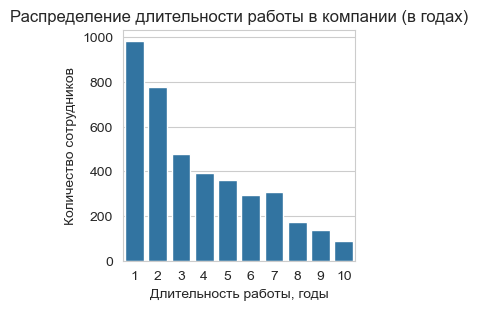

Информация по датафрейму 'X_train_quit':



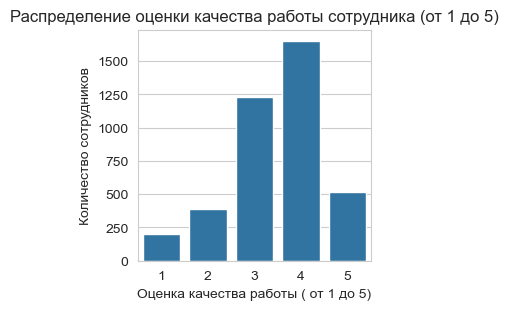

Информация по датафрейму 'X_train_quit':



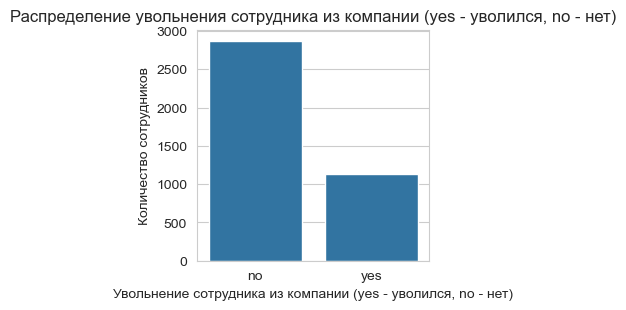

Информация по датафрейму 'X_test2':



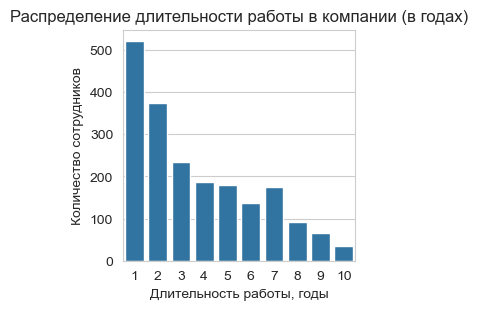

Информация по датафрейму 'X_test2':



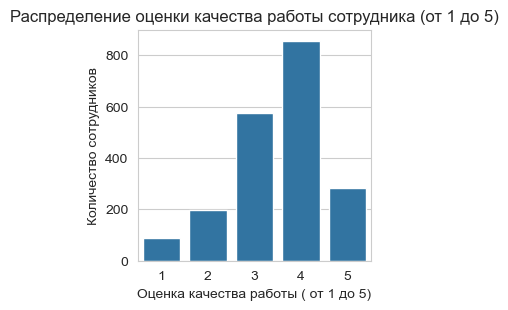

Информация по датафрейму 'y_test_quit':



<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

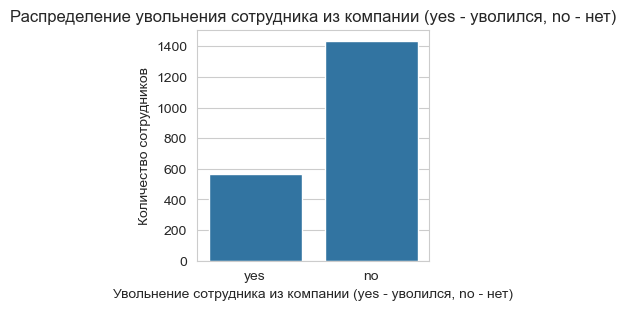

In [50]:
#посторим графики для дискретных числовых признаков столбцов для оценки распределения данных 

dfs = [ 
    X_train_quit,
    X_test2,
    y_test_quit
] 

dictionary = {
    'employment_years': ['Распределение длительности работы в компании (в годах)', 'Длительность работы, годы', 'Количество сотрудников'],
    'supervisor_evaluation':['Распределение оценки качества работы сотрудника (от 1 до 5)','Оценка качества работы ( от 1 до 5)', 'Количество сотрудников'],
    'salary': ['Распределение ежемесячной зарплаты сотрудника', 'Ежемесячная зарплата сотрудника', 'Количество сотрудников'],
    'quit':['Распределение увольнения сотрудника из компании (yes - уволился, no - нет)', 'Увольнение сотрудника из компании (yes - уволился, no - нет)', 'Количество сотрудников']
    }

X_test2.__name__ = 'X_test2' 
X_train_quit.__name__ = 'X_train_quit'
y_test_quit.__name__ = 'y_test_quit'

col_name_dis = ['employment_years', 'supervisor_evaluation', 'quit'] #дискретные признаки 
col_name_cont = ['salary'] #непрерывные признаки


#построим графики для дискретных признаков
for df in dfs:
    for column in col_name_dis:
        try:
            plt.figure(figsize=(3, 3))
            sns.countplot(data=df, x = column)
            print(f"Информация по датафрейму '{df.__name__}':\n")
            for tag, values in dictionary.items(): 
                if column == tag:
                    plt.title(values[0])
                    plt.xlabel(values[1])
                    plt.ylabel(values[2]) 
            plt.show();        
        except ValueError:
            continue

Информация по датафрейму 'X_train_quit':



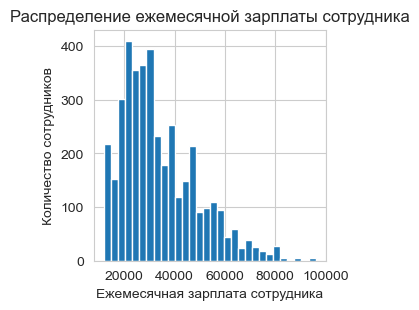

Информация по датафрейму 'X_test2':



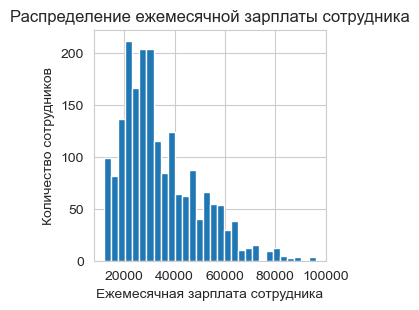

<Figure size 300x300 with 0 Axes>

In [51]:
#построим графики распределения для непрерывных признаков
for df in dfs:
    for column in col_name_cont:
        try:
            plt.figure(figsize=(3, 3))
            df[column].hist(bins=30)
            print(f"Информация по датафрейму '{df.__name__}':\n")
            for tag, values in dictionary.items(): 
                if column == tag:
                    plt.title(values[0])
                    plt.xlabel(values[1])
                    plt.ylabel(values[2]) 
            plt.show();        
        except ValueError:
            continue
        except KeyError:
            continue

Из гистограм видно что, признаки имеют распределение похожее на распределение Пуассона, в признаках по зарплате присутсвуют выбросы, в целом распеределения признаков тестовой и тренировочной выборок схожи.

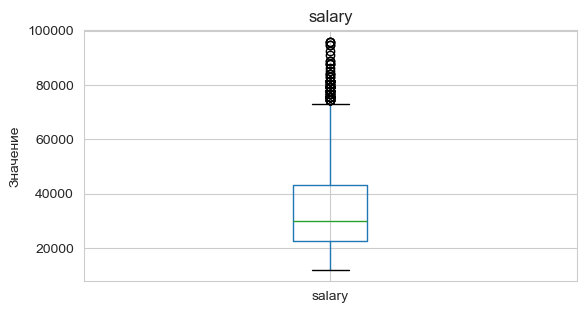

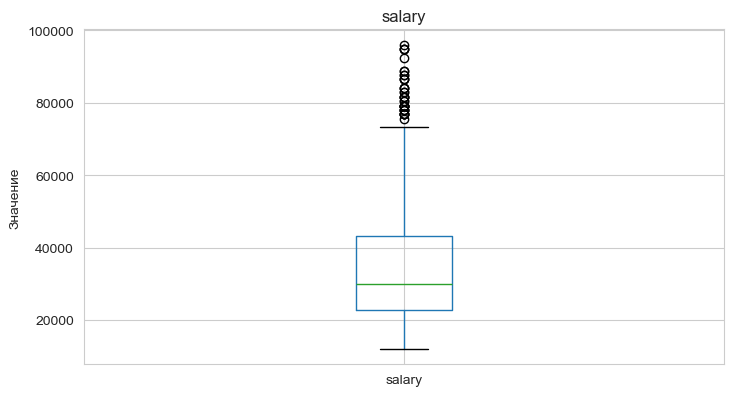

In [52]:
#для дополнительного анализа выбросов построим диаграмму размаха для непрерывных признаков

dfs2 = [ 
    X_train_quit,
    X_test2
] 
for df in dfs2:    
    if 'id' in col_name_cont:
        col_name.remove('id')
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(col_name_cont):
        plt.subplot(4,2,i+1)
        df.boxplot(column=column)
        plt.title(column)
       # plt.xlabel(column)
        plt.ylabel('Значение')
plt.tight_layout()
plt.show()

На диаграммах размаха так же наблюдаются выбросы в признаках зарплаты, но это нормальное явление.

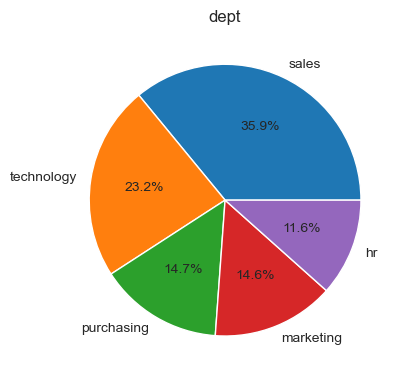

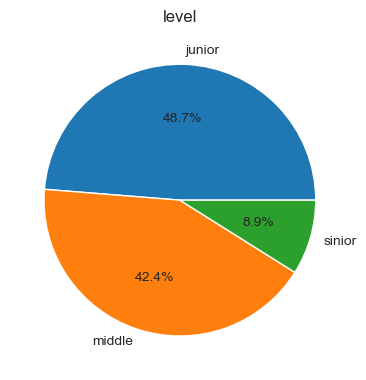

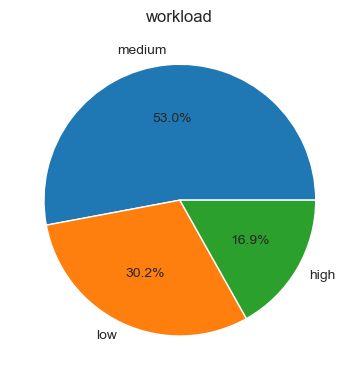

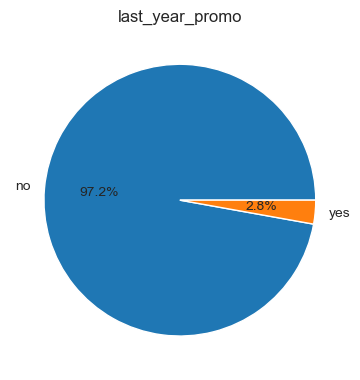

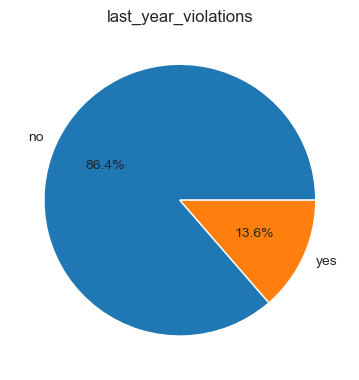

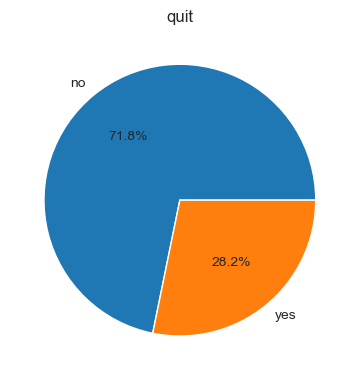

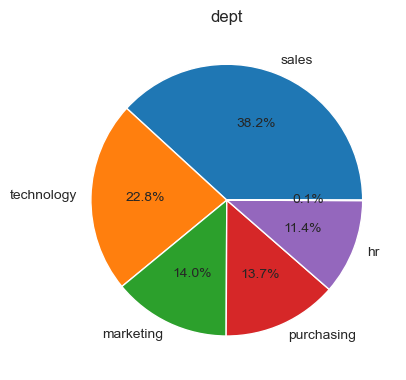

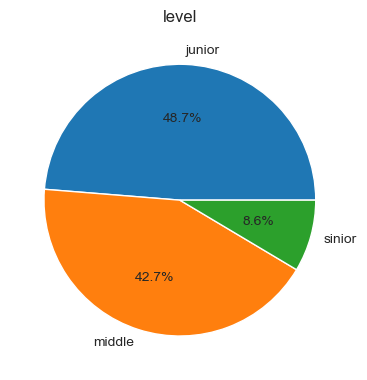

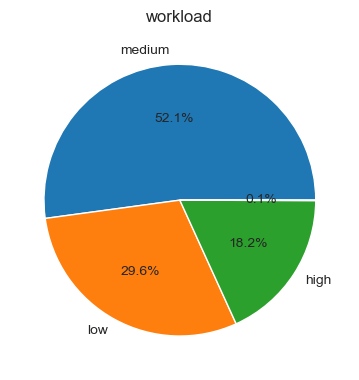

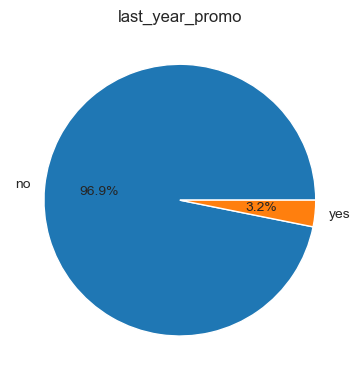

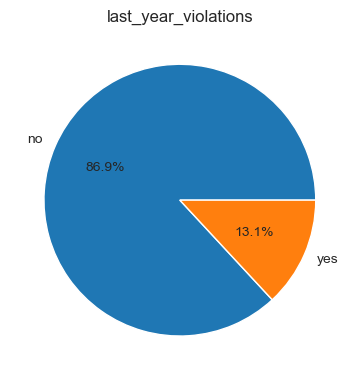

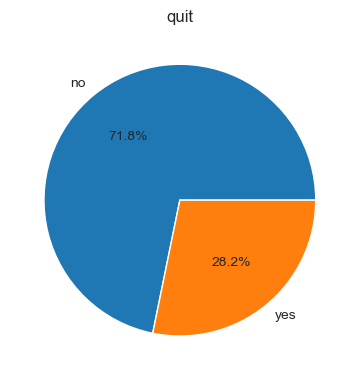

In [53]:
#для категориальных признаков датафрейма построим круговые диаграммы
for df in dfs:    
    plt.figure(figsize=(14, 15))
    col_name=df.select_dtypes(include='object').columns.tolist()
    if 'id' in col_name:
        col_name.remove('id')
    
    
    for i, column in enumerate(col_name):
        plt.subplot(3, 2, i + 1)
        data = df[column].value_counts()
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
        plt.title(column)
        plt.show()

__Корреляционный анализ__

Рассчитаем коэффициенты корреляции между всеми признаками и выведем их в виде тепловой карты. Из-за присутствия и категориальных и колличественных признаков будем использовать метод phik.

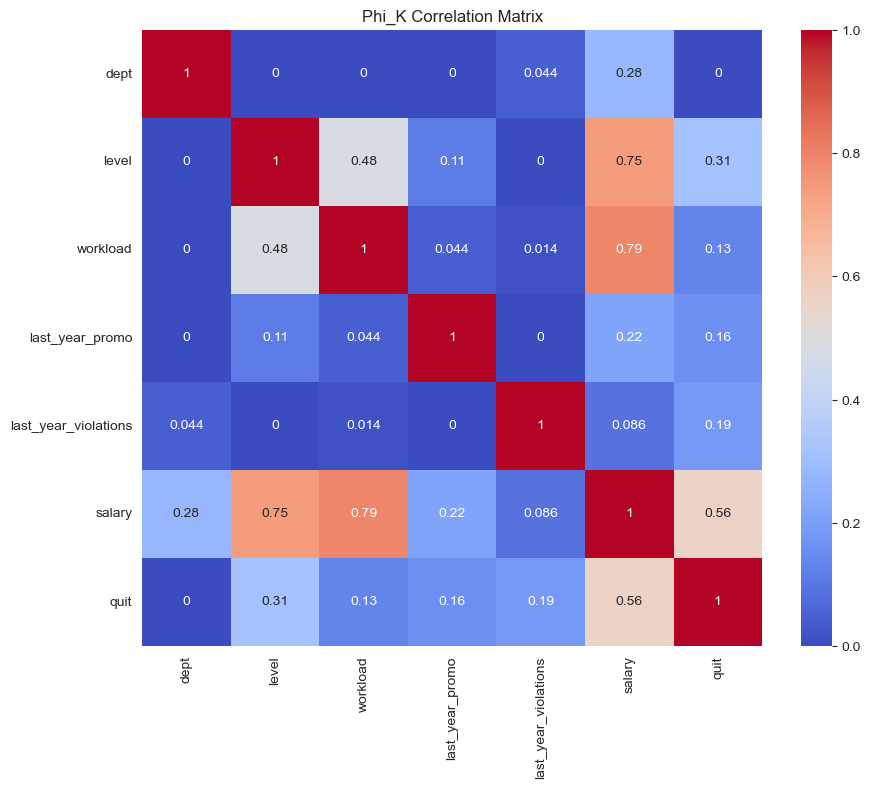

In [54]:
#исключим id, и дискретные признаки
df_train_quit_corr=X_train_quit.drop(columns=['id', 'employment_years', 'supervisor_evaluation'], axis=1)

#для метода нужен список с количественными признаками
num_columns = df_train_quit_corr.select_dtypes(include='number').columns.tolist()

# Вычисление матрицы корреляции с использованием phik
corr_matrix = df_train_quit_corr.phik_matrix(interval_cols = num_columns)

# Визуализация матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Вывод: Целевой признак quit - увольнение сотрудника из компании на тестовой выборки показал процент уволившихся равный 28.
Мультиколлинеарности не замечено.
Сильной связи (более 0.7) так же не обнаружено.

#### Составим портрет «уволившегося сотрудника»

In [55]:
#разделим датафрейм с тренировочными данными 
df_quit_yes = X_train_quit[X_train_quit['quit'] == 'yes']
df_quit_no = X_train_quit[X_train_quit['quit'] == 'no']
print(df_quit_yes.shape)
df_quit_no.shape

(1128, 10)


(2872, 10)

In [56]:
display(df_quit_yes.head())
df_quit_no.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
4,910140,marketing,junior,medium,2,no,no,5,25200,no
6,417070,technology,middle,medium,8,no,no,2,44400,no


Информация по датафрейму 'Уволившиеся':



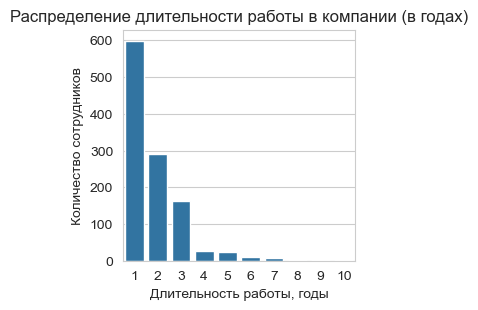

Информация по датафрейму 'Уволившиеся':



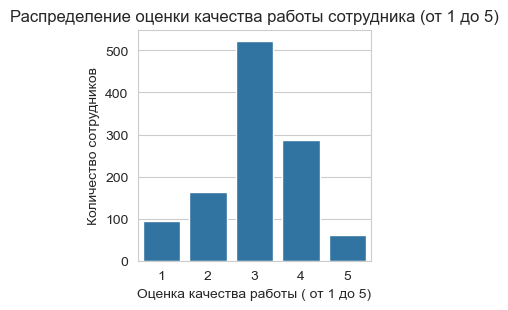

Информация по датафрейму 'Оставшиеся':



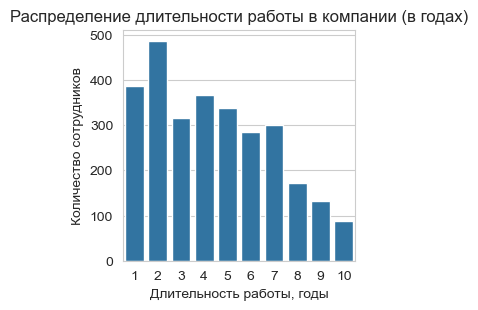

Информация по датафрейму 'Оставшиеся':



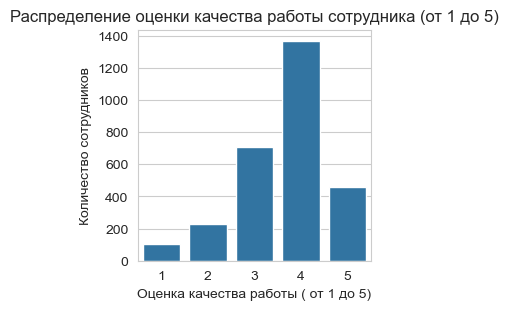

In [57]:
dfs = [ 
    df_quit_yes,
    df_quit_no
] 

dictionary = {
    'employment_years': ['Распределение длительности работы в компании (в годах)', 'Длительность работы, годы', 'Количество сотрудников'],
    'supervisor_evaluation':['Распределение оценки качества работы сотрудника (от 1 до 5)','Оценка качества работы ( от 1 до 5)', 'Количество сотрудников'],
    'salary': ['Распределение ежемесячной зарплаты сотрудника', 'Ежемесячная зарплата сотрудника', 'Количество сотрудников'],
    'quit':['Распределение увольнения сотрудника из компании (yes - уволился, no - нет)', 'Увольнение сотрудника из компании (yes - уволился, no - нет)', 'Количество сотрудников']
    }

df_quit_yes.__name__ = 'Уволившиеся' 
df_quit_no.__name__ = 'Оставшиеся'

col_name_dis = ['employment_years', 'supervisor_evaluation'] #дискретные признаки 
col_name_cont = ['salary'] #непрерывные признаки


#построим графики для дискретных признаков
for df in dfs:
    for column in col_name_dis:
        try:
            plt.figure(figsize=(3, 3))
            sns.countplot(data=df, x = column)
            print(f"Информация по датафрейму '{df.__name__}':\n")
            for tag, values in dictionary.items(): 
                if column == tag:
                    plt.title(values[0])
                    plt.xlabel(values[1])
                    plt.ylabel(values[2]) 
            plt.show();        
        except ValueError:
            continue

Информация по датафрейму 'Уволившиеся':



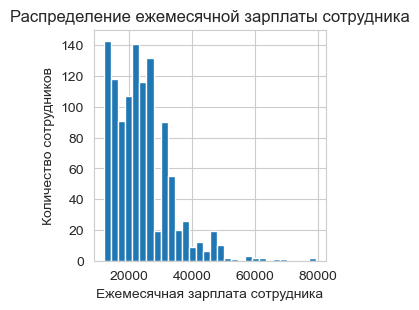

Информация по датафрейму 'Оставшиеся':



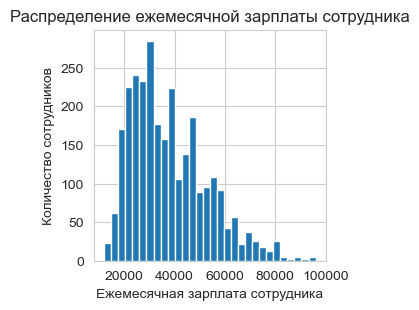

In [58]:
#построим графики распределения для непрерывных признаков
for df in dfs:
    for column in col_name_cont:
        try:
            plt.figure(figsize=(3, 3))
            df[column].hist(bins=30)
            print(f"Информация по датафрейму '{df.__name__}':\n")
            for tag, values in dictionary.items(): 
                if column == tag:
                    plt.title(values[0])
                    plt.xlabel(values[1])
                    plt.ylabel(values[2]) 
            plt.show();        
        except ValueError:
            continue
        except KeyError:
            continue

На гистограммах видно, что:
    - большая часть уволившихся проработала в компании 1-2 года
    - оценка качества работы уволившегося сотрудника в среднем равна 3
    - средняя зарплата уволившихся была в районе 20 тыс.

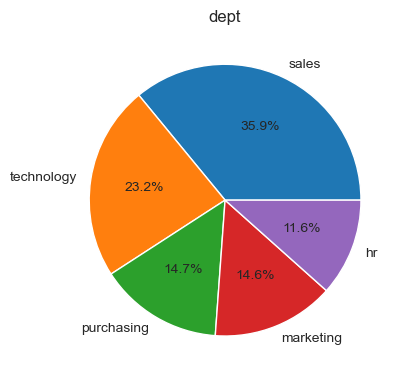

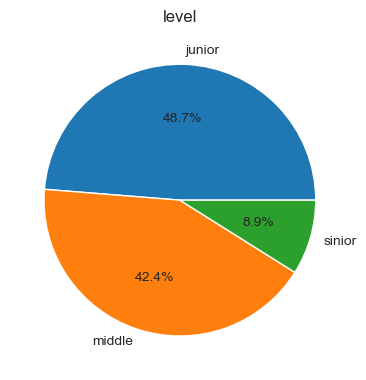

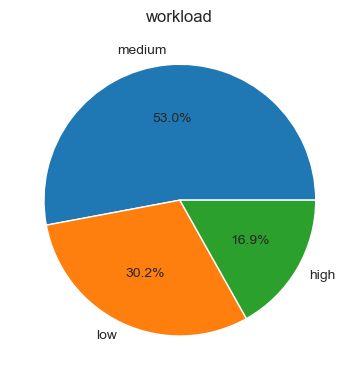

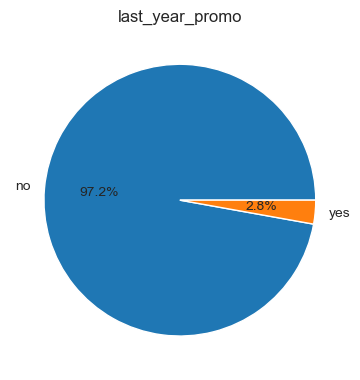

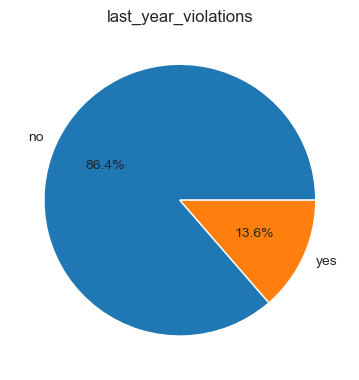

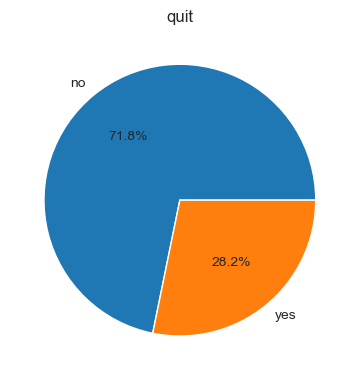

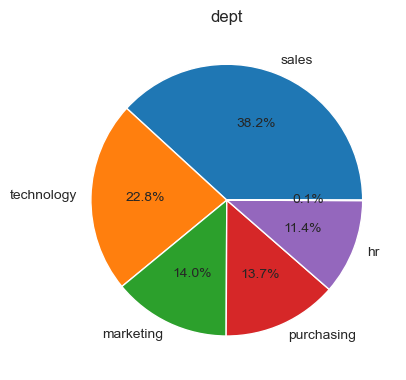

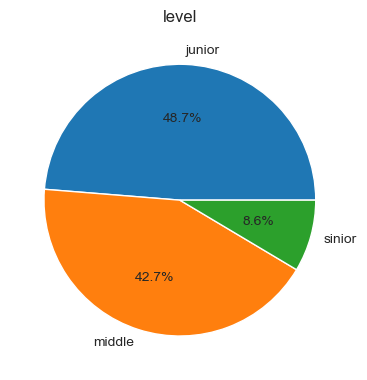

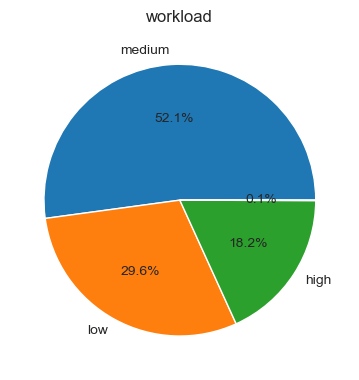

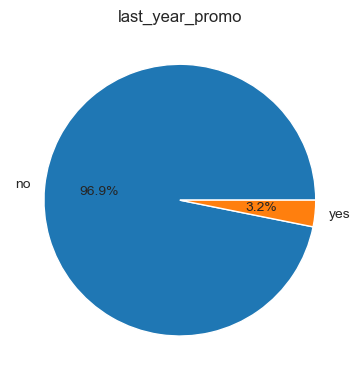

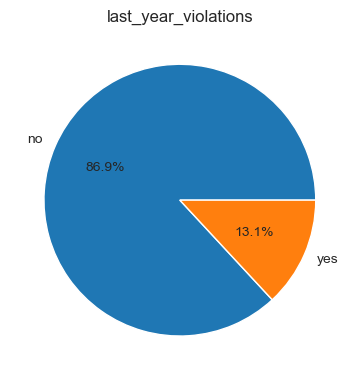

In [59]:
#для категориальных признаков датафрейма построим круговые диаграммы
for df in dfs2:    
    plt.figure(figsize=(14, 15))
    col_name=df.select_dtypes(include='object').columns.tolist()
    if 'id' in col_name:
        col_name.remove('id')
    
    
    for i, column in enumerate(col_name):
        plt.subplot(3, 2, i + 1)
        data = df[column].value_counts()
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
        plt.title(column)
        plt.show()

На круговых диаграммах видно, что:
 - больше всего сотрудников уволилось из департамента sales
 - 88.9% уволившихся были уровня junior
 - почти у половины уволившихся была низкая нагрузка

Вывод:

Характеристики уволившегося сотрудника:

    - уровень junior
    - работа в департаменте sales меньше 2 лет,
    - нагрузка на работе низкая,
    - оценка качества работы в среднем равна 3 по 5ти бальной шкале,
    - средняя зарплата в районе 20 тыс..

#### Проверка влияет ли уровень удовлетворённости сотрудника работой в компании на то, уволится ли он.

Визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [60]:
#получим уровень удовлетворенности работой в разрезе id из тестовой выборки
y_test=X_test_merge.loc[:,['id', 'job_satisfaction_rate']]
y_test.head()

,id,job_satisfaction_rate
0,485046,0.79
1,686555,0.72
2,467458,0.64
3,418655,0.60
4,789145,0.75


In [61]:
#объединим целевые признаки увольнения сотрудников
df_test_rate_quit = pd.merge(y_test,y_test_quit, on = 'id')
df_test_rate_quit.head(10)
#quit yes - уволился, no -нет

,id,job_satisfaction_rate,quit
0,485046,0.79,no
1,686555,0.72,no
2,467458,0.64,no
3,418655,0.60,no
4,789145,0.75,no
5,429973,0.67,yes
6,850699,0.36,yes
7,500791,0.73,no
8,767867,0.44,no
9,937235,0.22,yes


In [62]:
#разделим датафрейм на 2 категории
df_quit_yes2 = df_test_rate_quit[df_test_rate_quit['quit'] == 'yes'] #уволились
df_quit_no2 = df_test_rate_quit[df_test_rate_quit['quit'] == 'no'] #остались
print(df_quit_yes2.shape)
df_quit_no2.shape

(564, 3)


(1436, 3)

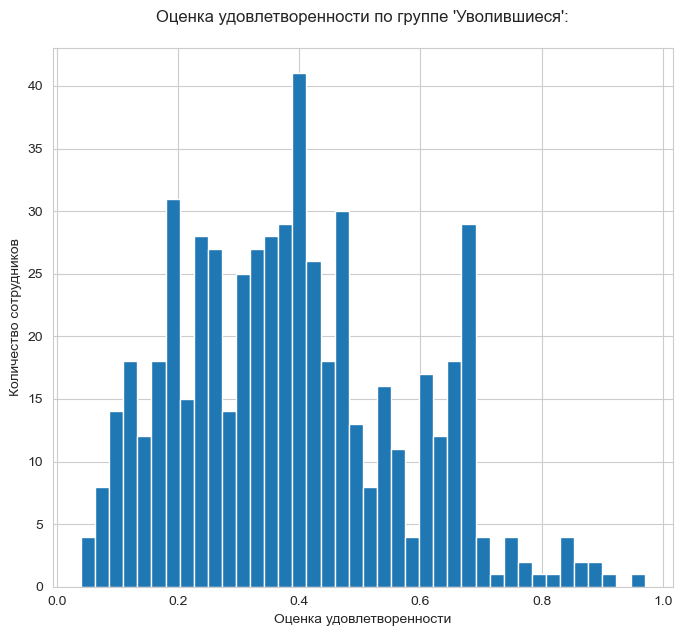

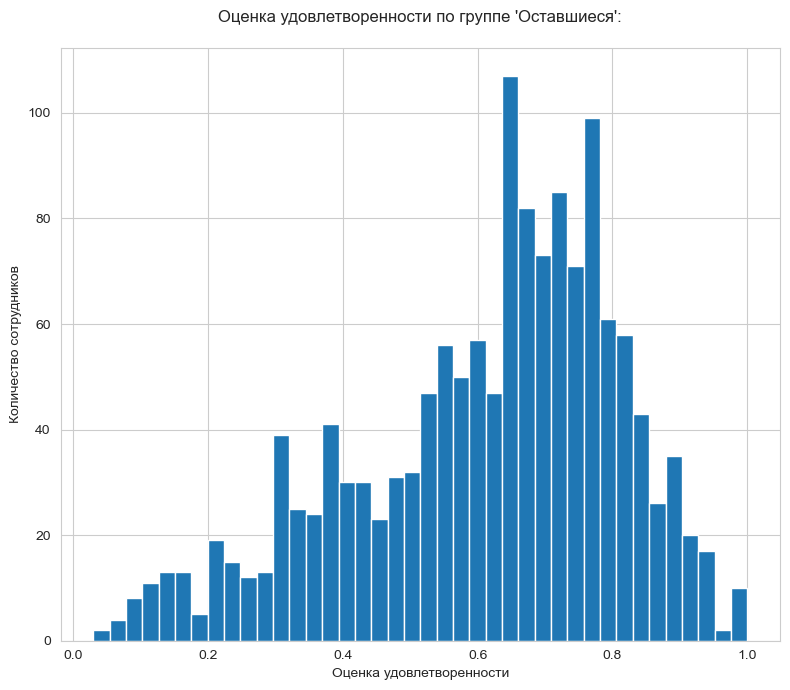

In [63]:
#посторим гистограммы для оценки распределения данных 
dfs3 = [ 
    df_quit_yes2,
    df_quit_no2
]
df_quit_yes2.__name__ = 'Уволившиеся' 
df_quit_no2.__name__ = 'Оставшиеся'

for df in dfs3:    
    plt.figure(figsize=(8, 7))
    df['job_satisfaction_rate'].hist(bins=40)
    plt.title(f"Оценка удовлетворенности по группе '{df.__name__}':\n")
    plt.xlabel('Оценка удовлетворенности')
    plt.ylabel('Количество сотрудников')
            
plt.tight_layout()
plt.show();

In [64]:
#выведем средние значения уровня удовлетворенности работой в компании
print(f"Оценка удовлетворенности по группе Уволившиеся:'{df_quit_yes2['job_satisfaction_rate'].mean().round(2)}'")
print(f"Оценка удовлетворенности по группе Оставшиеся: '{df_quit_no2['job_satisfaction_rate'].mean().round(2)}'")

Оценка удовлетворенности по группе Уволившиеся:'0.39'
Оценка удовлетворенности по группе Оставшиеся: '0.61'


На графиках видно, что уровень удовлетворенности работой в компании у оставшихся сотрудников в среднем находится в диапазоне от 0.6 до 0.8
У уволившихся сотрудников уровень удовлетвореннсти в районе 0.4.
Делаем вывод, что уровень удовлетворенности влияет на то останется ли сотрудник к компании или нет.

### Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [65]:
#просмотр тестовой выборки
X_test2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [66]:
#просмотр тренировочной выборки
X_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [67]:
#добавим в исходные датафреймы X_train_quit и X_test новый входной признак, 
#а именно уровень удовлетворенности, предсказанный лучшей моделью из первой задачи
#удалим из тренировочной выборки второй задачи целевой признак quit
y_train_quit = X_train_quit['quit']
X_train_quit = X_train_quit.drop(['quit'], axis=1)

In [68]:
#предскажем значения `job_satisfaction_rate` на тренировочной выборке второй задачи X_train_quit 
#с помощью лучшей модели первой задачи
y_train_pred2 = grid_search.predict(X_train_quit)
y_test_pred2 = grid_search.predict(X_test2)

In [69]:
# теперь добавим получившиеся предсказания в тренировочный и тестовый датафремы с входными признаками
X_train_quit['job_satisfaction_rate'] = y_train_pred2
X_test2['job_satisfaction_rate'] = y_test_pred2

# проверим
display(X_train_quit.head())
X_test2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,0.634250
1,814010,sales,junior,medium,2,no,no,4,27600,0.826394
2,155091,purchasing,middle,medium,5,no,no,1,37200,0.389900
3,257132,sales,junior,medium,2,no,yes,3,24000,0.349800
4,910140,marketing,junior,medium,2,no,no,5,25200,0.761159


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.869177
1,686555,hr,junior,medium,1,no,no,4,30000,0.684156
2,467458,sales,middle,low,5,no,no,4,19200,0.654361
3,418655,sales,middle,low,6,no,no,4,19200,0.656705
4,789145,hr,middle,medium,5,no,no,5,40800,0.789665


In [70]:
#целевые признаки
display(y_test_quit)
display(y_train_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


0        no
1        no
2        no
3       yes
4        no
       ... 
3995     no
3996     no
3997    yes
3998     no
3999    yes
Name: quit, Length: 4000, dtype: object

Вывод: мы получили 2 датафрейма с входными признаками для тестовой (X_test2) и тренировочной выборки (X_train_quit). Добавили предсказанный признак job_satisfaction_rate. Выделили отдельно целевой признак для тренировочной выборки y_train_quit.
И теперь нужно предсказать целевой признак quit (y_test2) для тестовой выборки и сравнить с данным y_test_quit.

### Подготовка данных

Перечислим особенности данных:

Целевой признак — quit категориальный yes , no, для предсказания потребуется модель классификации.

Категориальные признаки: dept, last_year_promo, last_year_violations, нужно кодировать с помощью OneHotEncoder

Порядковые категориальные признаки: level, workload, закодируем с помощью OrdinalEncoder

Количественные признаки: employment_years, supervisor_evaluation, salary.

In [71]:
#проверим датасеты на совместимость
print(y_test_quit.shape)
X_test2.shape

(2000, 2)


(2000, 10)

In [72]:
y_test_quit

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


In [73]:
#объединим датасеты
X_test_merge2 = pd.merge(X_test2, y_test_quit, on = 'id', how = 'inner')
print(X_test_merge2.head())
X_test_merge2.shape

       id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  \
0                   no                      5   28800               0.869177   
1                   no                      4   30000               0.684156   
2                   no                      4   19200               0.654361   
3                   no                      4   19200               0.656705   
4                   no                      5   40800               0.789665   

  quit  
0   no  
1   no  
2   no  
3   no  
4   no  


(2000, 11)

In [74]:
#проверим размерность и дубликаты
print(X_test_merge2.shape)
X_test_merge2.duplicated().sum()
# разделим на входные и целевой признак
y_test_quit = X_test_merge2['quit']
X_test2= X_test_merge2.drop(['quit', 'id'], axis=1)

(2000, 11)


In [75]:
X_test2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.869177
1,hr,junior,medium,1,no,no,4,30000,0.684156
2,sales,middle,low,5,no,no,4,19200,0.654361
3,sales,middle,low,6,no,no,4,19200,0.656705
4,hr,middle,medium,5,no,no,5,40800,0.789665


In [76]:
#удалим id из тренировочной выборки
X_train_quit=X_train_quit.drop(['id'], axis=1)

In [77]:
# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years',  'supervisor_evaluation']

In [78]:
# преобразование целевого признака
target = y_test_quit
# Инициализировать LabelEncoder  
le = LabelEncoder()
# Применим кодировщик к данным и преобразуем категории в целые числа с инвертированием 
encoded_target = 1 - le.fit_transform(target)  
y_test_quit=encoded_target
y_test_quit
# 0 - уволился, 1 - нет

array([1, 1, 1, ..., 0, 1, 1])

In [79]:
# преобразование целевого признака
target2 = y_train_quit
# Инициализировать LabelEncoder  
le = LabelEncoder()
# Применим кодировщик к данным и преобразуем категории в целые числа с инвертированием 
encoded_target = 1 - le.fit_transform(target2)  
y_train_quit=encoded_target
y_train_quit
# 0 - уволился, 1 - нет

array([1, 1, 1, ..., 0, 1, 0])

In [80]:
y_test_quit=pd.Series(y_test_quit)
y_test_quit

0       1
1       1
2       1
3       1
4       1
       ..
1995    0
1996    0
1997    0
1998    1
1999    1
Length: 2000, dtype: int32

In [81]:
y_train_quit=pd.Series(y_train_quit)
y_train_quit


0       1
1       1
2       1
3       0
4       1
       ..
3995    1
3996    1
3997    0
3998    1
3999    0
Length: 4000, dtype: int32

In [82]:
display(X_train_quit.head())
display(y_train_quit.head())
display(X_test2.head())
display(y_test_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.634250
1,sales,junior,medium,2,no,no,4,27600,0.826394
2,purchasing,middle,medium,5,no,no,1,37200,0.389900
3,sales,junior,medium,2,no,yes,3,24000,0.349800
4,marketing,junior,medium,2,no,no,5,25200,0.761159


0    1
1    1
2    1
3    0
4    1
dtype: int32

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.869177
1,hr,junior,medium,1,no,no,4,30000,0.684156
2,sales,middle,low,5,no,no,4,19200,0.654361
3,sales,middle,low,6,no,no,4,19200,0.656705
4,hr,middle,medium,5,no,no,5,40800,0.789665


0    1
1    1
2    1
3    1
4    1
dtype: int32

In [83]:
#создадим функцию для замены пропусков на nan
replace_miss=FunctionTransformer(lambda x: x.replace(' ', np.nan))

In [84]:
# cоздаём пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline([
            ('replace_miss', replace_miss), #пропуски заменяем на nan
    
            (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
                #nan заменяем на моду, самое частое значение
            ),
        
        (    'ohe', 
            OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
         
        )
])

In [85]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns:
ord_pipe = Pipeline([
        ('replace_miss', replace_miss),
        (
            'simpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior', np.nan],
                    ['low', 'medium', 'high', np.nan]
                ], 
                handle_unknown='use_encoded_value', # кодируем неизвестные категории пропусками
                unknown_value=-1
            )
        )
])

In [86]:
# создайте общий пайплайн 
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough',
    force_int_remainder_cols=False
)
print(data_preprocessor)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('replace_miss',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000176C2E056C0>)),
                                                 ('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_...
                                                  FunctionTransformer(func=<function <lambda> at 0x00000176C2E056C0>)),
                                                 ('

In [87]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [88]:
#создаем словарь для моделей
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        # название модели
        'models': [KNeighborsClassifier()],
        # указываем гиперпараметр модели n_neighbors
        'models__n_neighbors': range(1, 20),
        # указываем список методов масштабирования
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

### Обучение модели

In [89]:
#запускаем автоматический подбор гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [90]:
#запускаем автоматический подбор гиперпараметров
randomized_search.fit(X_train_quit, y_train_quit)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('replace_miss',
                                                                                                FunctionTransformer(func=<function <lambda> at 0x00000176C2E056C0>)),
                                                                                               ('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='fir...
                                         'models__max_depth': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [91]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('replace_miss',
                                                                   FunctionTransformer(func=<function <lambda> at 0x00000176C2E056C0>)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                           

In [92]:
X_test2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.869177
1,hr,junior,medium,1,no,no,4,30000,0.684156
2,sales,middle,low,5,no,no,4,19200,0.654361
3,sales,middle,low,6,no,no,4,19200,0.656705
4,hr,middle,medium,5,no,no,5,40800,0.789665


In [93]:
X_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,sales,middle,high,2,no,no,4,54000,0.634250
1,sales,junior,medium,2,no,no,4,27600,0.826394
2,purchasing,middle,medium,5,no,no,1,37200,0.389900
3,sales,junior,medium,2,no,yes,3,24000,0.349800
4,marketing,junior,medium,2,no,no,5,25200,0.761159


In [94]:
#получим вероятности
y_test_probas2 = randomized_search.predict_proba(X_test2)[:,1]
y_test_probas2

array([0.9009009 , 0.95547945, 0.93571429, ..., 0.03271028, 0.97119342,
       0.95515695])

In [95]:
#рассчитаем метрику для тестовой выборки
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_quit, y_test_probas2)}')

Метрика ROC-AUC на тестовой выборке: 0.9252355834765602


__Вывод по разделу__

 Критерием успеха по условиям задачи - метрика ROC-AUC ≥0.91 на тестовой выборке. Мы получили мерику ROC-AUC равную 0,918. Подбор гиперпараметров моделей осуществляли с помощью случайного поиска. Лучшей моделью определена DecisionTreeClassifier с гиперпараметрами max_depth=5, random_state=42.

## Общий вывод

 В рамках данного проекта требовалось выполнить две задачи:
 - создать модель, которая позволит спрогнозировать уровень удовлетворенности сотрудника, чтобы определить влияет ли он на отток содрудников из компании;
 - создать модель, которая позволит предсказать увольнение сотрудника, чтобы внезапные увольнения не создали высоких рисков на компании.
 
 Для решения первой задачи была подобрана лучшая модель, на основе имеющихся данных, из нескольких вариантов. Ей оказалась RandomForestRegressor со значением метрики SMAPE на тестовой выборке 12.41, это соответствует критерию успеха из условий задачи, SMAPE ≤15 на тестовой выборке.
  
 Для решения второй задачи была подобрана лучшая модель, из моделей классификации. Ей оказалась DecisionTreeClassifier предсказывающая результат с точность 92%
 
 Для оценки качества модели применялась метрика ROC-AUC, так как в данных по целевому признаку присутствует дисбаланс и целевой признак бинарный.
 
 На этапе подготовки данных для обеих задач были выполнены:
 
 - предобработка данных с проверкой пропусков и дубликатов,

 - выполнен исследовательский анализ в ходе которого:
         - составлено описание особенностей уволившихся сотрудников:
                - уровень junior
                - работа в департаменте sales меньше 2 лет,
                - нагрузка на работе низкая,
                - оценка качества работы в среднем равна 3 по 5ти бальной шкале,
                - средняя зарплата в районе 20 тыс.
         - определено, что уровень удовлетворенности работой влияет а то, останется сотрудник в компании или нет.
    
    
- выполнен корреляционный анализ в ходе которого проверялось наличие мультиколлениарности и сильной связанности признаков,

- подбор параметров, подготовка моделей и выбор лучшей выполнялся с помощью пайплайнов.

Общие рекомендации для бизнеса.

Вероятнее, кроме признаков представленных в проекте, на удовлетворенность работой в компании и вероятность увольнения влияют и другие показатели, например наличие социальных льгот, общественной жизни и т.д. , а возможно эти показатели скрыты в признаке "уровень удовлетворенности", поэтому для более четкой картины и детального исследования, можно было бы собрать более расширенной датасет и провести предсказания на нем.

Результаты данного исследования можно использовать для корректировки политики компании в отношении уволившихся сотрудников уровня junior.
 